# EDA para Modelo de Recomendacion

Importe de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Se revisan las distintas columnas disponibles

In [2]:
# Se carga el dataset original "movies_dataset.csv"
eda = pd.read_csv("../Data/limpio1.csv")
eda.isna().sum()

budget                            0
id                                0
original_language                11
overview                        941
popularity                        0
release_date                      0
revenue                           0
runtime                         246
status                           80
tagline                       25026
title                             0
vote_average                      0
vote_count                        0
return                            0
release_year                      0
release_day                       0
genres_ids                        0
genres_names                      0
production_companies_id           0
production_companies_names        0
production_countries_iso          0
production_countries_names        0
spoken_languages_iso              0
spoken_languages_name             0
belongs_to_collection_id      40954
belongs_to_collection_name    40954
cast_names                        0
director_name               

### Primeramente, borramos columnas innecesarias

Se Eliminan las siguientes columnas por su irrelevancia para el modelo:
<ul>
<li>-budget
<li>-oiginal_language
<li>-release_date
<li>-revenue
<li>-runtime
<li>-vote_count
<li>-return
<li>-release_year
<li>-release_day
<li>-genres_name (queda genre_id)
<li>-production_company_name (queda production_company_id)
<li>-production_country_name (queda production_company_iso)
<li>-spoken_language_name (queda spoken_language_iso)
<li>-belongs_to_collection_name (queda belongs_to_collection_id)
<li>-tagline (muchos vacíos y poca información)

</ul>


### Belongs_to_collections_id, a pesar de tener 40.954 registros vacíos, se mantiene para su uso en el modelo de recomendacion

In [3]:
columnas_eliminar = ['budget', 
                    'original_language', 
                    'release_date', 'revenue', 
                    'runtime', 'vote_count',
                    'return',
                    'release_date',
                    'release_year',
                    'release_day',
                    'genres_names',
                    'tagline',
                    'production_companies_names',
                    'production_countries_names',
                    'spoken_languages_name',
                    'belongs_to_collection_name']
eda.drop(columns=columnas_eliminar, inplace=True)

### Quedamos con las siguientes columnas y sus respectivos datos vacios


In [4]:
eda.isna().sum()

id                              0
overview                      941
popularity                      0
status                         80
title                           0
vote_average                    0
genres_ids                      0
production_companies_id         0
production_countries_iso        0
spoken_languages_iso            0
belongs_to_collection_id    40954
cast_names                      0
director_name                 835
dtype: int64

### Eliminación de datos duplicados

In [7]:
print(eda.duplicated().sum())
print(eda.shape)

92
(45451, 13)


Se eliminan los 92 duplicados

In [8]:
eda = eda.drop_duplicates()
eda.shape

(45359, 13)

## Se analiza la columna 'status'

In [6]:
eda['status'].unique()

array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

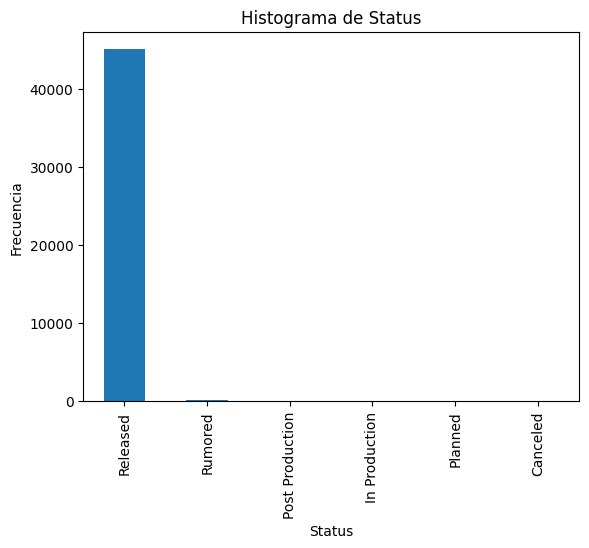

In [7]:
# Se grafican las distintas categorías en un histograma
frecuencia = eda['status'].value_counts()
frecuencia.plot(kind='bar')
plt.xlabel('Status')
plt.ylabel('Frecuencia')
plt.title('Histograma de Status')
plt.show()

La única categoría que vamos a utilizar en el modelo será 'Released', por lo que eliminamos las entradas que películas que no estén estrenadas, y se elimina la columna 'status

In [8]:
eda=eda.loc[eda['status']=='Released']
eda =eda.drop(columns='status')

In [9]:
eda.isna().sum()


id                              0
overview                      907
popularity                      0
title                           0
vote_average                    0
genres_ids                      0
production_companies_id         0
production_countries_iso        0
spoken_languages_iso            0
belongs_to_collection_id    40534
cast_names                      0
director_name                 809
dtype: int64

### Como el modelo se basará principalmente en similitud de conceptos en 'overview', y similitud en 'director_name' se decide eliminar las filass que tengan 'overview' y 'directors_name' vacío


In [10]:
eda = eda.dropna(subset=['overview', 'director_name'])
eda.isna().sum()

id                              0
overview                        0
popularity                      0
title                           0
vote_average                    0
genres_ids                      0
production_companies_id         0
production_countries_iso        0
spoken_languages_iso            0
belongs_to_collection_id    38975
cast_names                      0
director_name                   0
dtype: int64

### Analizamos las 2 columnas numericas 'popularity' y 'score_average' orbservando que no hay correlación importante pero si outliers

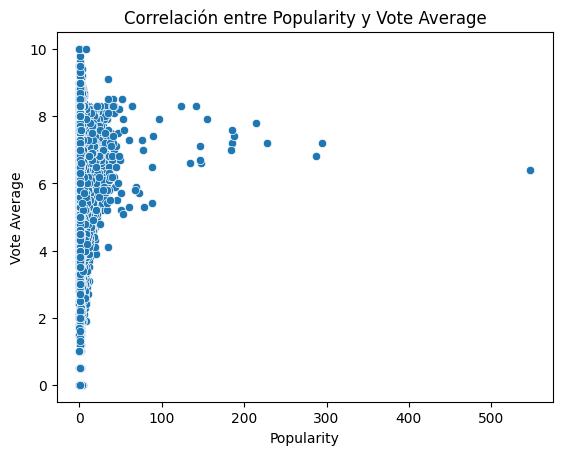

              popularity  vote_average
popularity      1.000000      0.151954
vote_average    0.151954      1.000000


In [11]:
sns.scatterplot(data=eda, x='popularity', y='vote_average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.title('Correlación entre Popularity y Vote Average')
plt.show()

correlacion = eda[['popularity', 'vote_average']].corr()
print(correlacion)

filtro = eda[eda['popularity']>200]
filtro

### Se Revisan los Outliers de 'popularity' pero se deciden dejar por ser películas de alta demanda para el modelo

In [12]:
filtro = eda[eda['popularity']>200]
filtro

,id,overview,popularity,title,vote_average,genres_ids,production_companies_id,production_countries_iso,spoken_languages_iso,belongs_to_collection_id,cast_names,director_name
24473,177572,The special bond that develops between plus-si...,213.849907,Big Hero 6,7.8,"[12, 10751, 16, 28, 35]","[2, 6125]",['US'],['en'],NaN,"['Scott Adsit', 'Ryan Potter', 'Daniel Henney'...",Chris Williams
30731,211672,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,Minions,6.4,"[10751, 16, 12, 35]","[33, 6704]",['US'],['en'],86066.0,"['Sandra Bullock', 'Jon Hamm', 'Michael Keaton...",Kyle Balda
33383,297762,An Amazon princess comes to the world of Man t...,294.337037,Wonder Woman,7.2,"[28, 12, 14]","[444, 507, 6194, 9993, 9995, 81620, 83838]",['US'],"['de', 'en']",468552.0,"['Gal Gadot', 'Chris Pine', 'Robin Wright', 'D...",Patty Jenkins
42224,321612,A live-action adaptation of Disney's version o...,287.253654,Beauty and the Beast,6.8,"[10751, 14, 10749]","[2, 10227]","['GB', 'US']",['en'],NaN,"['Emma Watson', 'Dan Stevens', 'Luke Evans', '...",Bill Condon
43639,339403,After being coerced into working for a crime b...,228.032744,Baby Driver,7.2,"[28, 80]","[443, 559, 2531, 10163, 31922]","['GB', 'US']",['en'],NaN,"['Ansel Elgort', 'Lily James', 'Kevin Spacey',...",Edgar Wright


## Nube de palabra para ver las palabras más repetidas en columna 'overview'

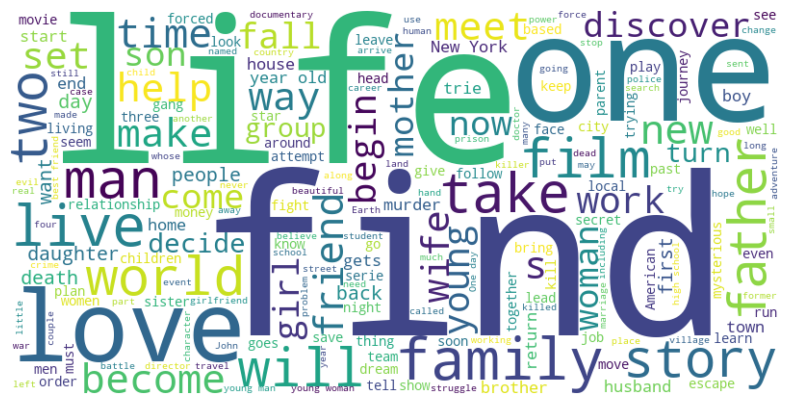

In [13]:
text = ' '.join(eda['overview'].astype(str))

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Nube de palabras en columna 'title'

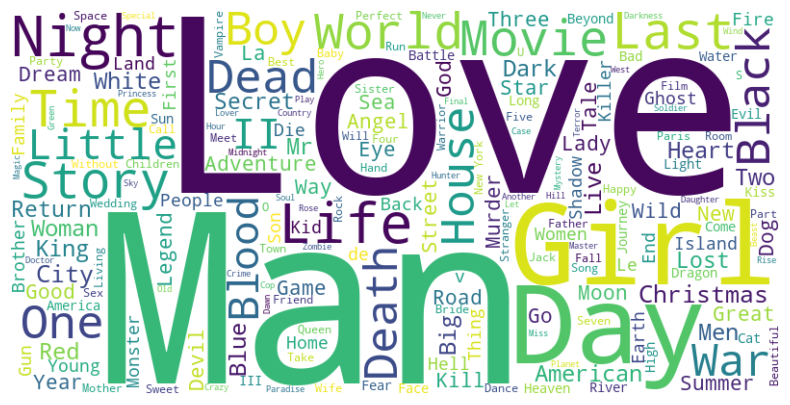

In [14]:
text = ' '.join(eda['title'].astype(str))

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

array([2.1946943e+01, 1.7015539e+01, 1.1712900e+01, ..., 9.0300700e-01,
       3.5030000e-03, 1.6301500e-01])

### Analisis de la distribución en columna 'popularity'

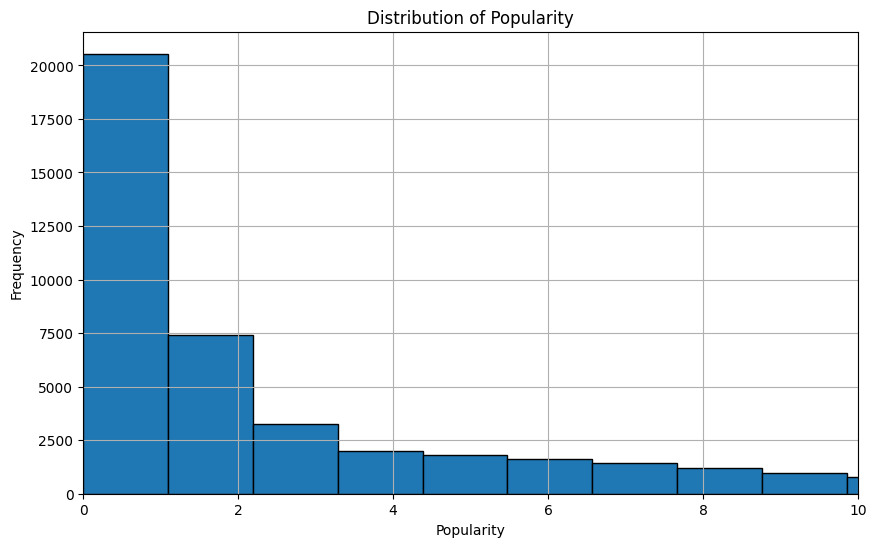

In [31]:
popularity_data = eda['popularity']

# Crea el histograma
plt.figure(figsize=(10, 6))  # Tamaño opcional para ajustar el gráfico
plt.hist(popularity_data, bins=500, edgecolor='black')  # Ajusta el número de bins según tu preferencia
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')
plt.grid(True)
plt.xlim(0,10)
plt.show()

### Análisis de la Distribución de los valores de 'score_average'

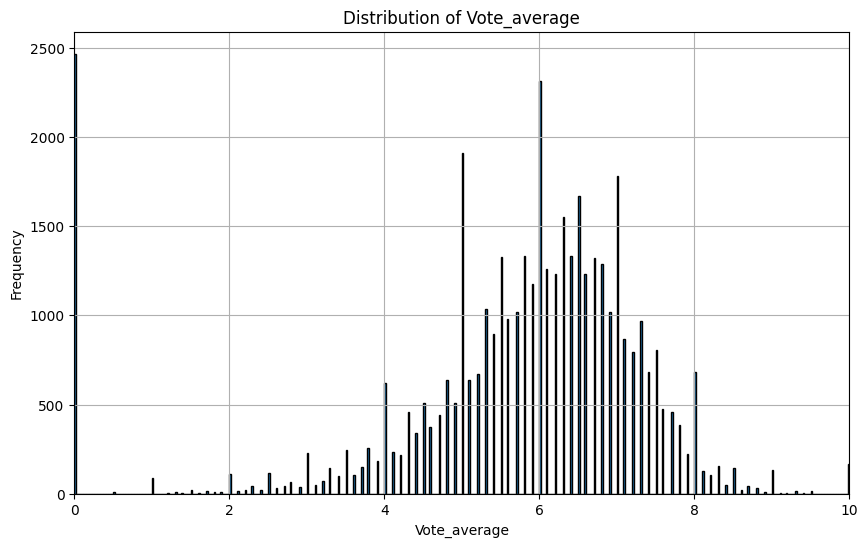

In [34]:
popularity_data = eda['vote_average']

# Crea el histograma
plt.figure(figsize=(10, 6))  # Tamaño opcional para ajustar el gráfico
plt.hist(popularity_data, bins=500, edgecolor='black')  # Ajusta el número de bins según tu preferencia
plt.xlabel('Vote_average')
plt.ylabel('Frequency')
plt.title('Distribution of Vote_average')
plt.grid(True)
plt.xlim(0,10)
plt.show()